# ====================================================================
# Arabic Named Entity Recognition (NER) with AraBERT
# ====================================================================
# This notebook demonstrates fine-tuning AraBERT for Arabic NER using 
# the MAFAT dataset with BILOU tagging scheme.
# ====================================================================

# ====================================================================
# 📦 SECTION 1: Installation and Imports
# ====================================================================

In [1]:
!pip install evaluate seqeval transformers==4.55.0 
from IPython.display import clear_output

clear_output()

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from datasets import load_dataset
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate

2025-10-26 10:52:34.853686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761475955.046026      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761475955.103727      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ====================================================================
# 📊 SECTION 2: Dataset Loading and Exploration
# ====================================================================

In [4]:
dataset = load_dataset("iahlt/arabic_ner_mafat", split="train")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/52.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40000 [00:00<?, ? examples/s]

In [5]:
print(f"\n📈 Dataset Info:")
print(f"   Total examples: {len(dataset):,}")
print(f"   Features: {list(dataset.features.keys())}")

# Display sample example
print(f"\n📝 Sample Example:")
sample = dataset[0]
print(f"   Text: {sample['text'][:100]}...")
print(f"   Tokens: {sample['tokens'][:10]}")
print(f"   Tags: {sample['raw_tags'][:10]}")


📈 Dataset Info:
   Total examples: 40,000
   Features: ['tokens', 'raw_tags', 'ner_tags', 'spaces', 'spans', 'record', 'text']

📝 Sample Example:
   Text: البروفسور محمود خليل...
   Tokens: ['البروفسور', 'محمود', 'خليل']
   Tags: ['B-TTL', 'B-PER', 'L-PER']


# ====================================================================
# 🔀 SECTION 3: Train-Test Split
# ====================================================================

In [6]:
main_split = dataset.train_test_split(test_size=0.05, seed=42)

In [7]:
main_split

DatasetDict({
    train: Dataset({
        features: ['tokens', 'raw_tags', 'ner_tags', 'spaces', 'spans', 'record', 'text'],
        num_rows: 38000
    })
    test: Dataset({
        features: ['tokens', 'raw_tags', 'ner_tags', 'spaces', 'spans', 'record', 'text'],
        num_rows: 2000
    })
})

In [8]:
training = main_split['train']
testing = main_split['test']

In [9]:
print(f"\n✅ Split complete:")
print(f"   Training samples: {len(training):,}")
print(f"   Testing samples: {len(testing):,}")


✅ Split complete:
   Training samples: 38,000
   Testing samples: 2,000


# ====================================================================
# 🏷️ SECTION 4: Label Extraction and Mapping
# ====================================================================

In [10]:
raw_tags = dataset["raw_tags"]

unique_tags = sorted(set(tag for tags in raw_tags for tag in tags))
unique_tags = unique_tags[-1:] + unique_tags[:-1]
print(unique_tags)

['O', 'B-ANG', 'B-DUC', 'B-EVE', 'B-FAC', 'B-GPE', 'B-INFORMAL', 'B-LOC', 'B-MISC', 'B-ORG', 'B-PER', 'B-TIMEX', 'B-TTL', 'B-WOA', 'I-ANG', 'I-DUC', 'I-EVE', 'I-FAC', 'I-GPE', 'I-INFORMAL', 'I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'I-TIMEX', 'I-TTL', 'I-WOA', 'L-ANG', 'L-DUC', 'L-EVE', 'L-FAC', 'L-GPE', 'L-INFORMAL', 'L-LOC', 'L-MISC', 'L-ORG', 'L-PER', 'L-TIMEX', 'L-TTL', 'L-WOA']


In [11]:
label2id = {key: value for value, key in enumerate(unique_tags)}
id2label = {value: key for key, value in label2id.items()}

In [12]:
label2id

{'O': 0,
 'B-ANG': 1,
 'B-DUC': 2,
 'B-EVE': 3,
 'B-FAC': 4,
 'B-GPE': 5,
 'B-INFORMAL': 6,
 'B-LOC': 7,
 'B-MISC': 8,
 'B-ORG': 9,
 'B-PER': 10,
 'B-TIMEX': 11,
 'B-TTL': 12,
 'B-WOA': 13,
 'I-ANG': 14,
 'I-DUC': 15,
 'I-EVE': 16,
 'I-FAC': 17,
 'I-GPE': 18,
 'I-INFORMAL': 19,
 'I-LOC': 20,
 'I-MISC': 21,
 'I-ORG': 22,
 'I-PER': 23,
 'I-TIMEX': 24,
 'I-TTL': 25,
 'I-WOA': 26,
 'L-ANG': 27,
 'L-DUC': 28,
 'L-EVE': 29,
 'L-FAC': 30,
 'L-GPE': 31,
 'L-INFORMAL': 32,
 'L-LOC': 33,
 'L-MISC': 34,
 'L-ORG': 35,
 'L-PER': 36,
 'L-TIMEX': 37,
 'L-TTL': 38,
 'L-WOA': 39}

In [13]:
id2label

{0: 'O',
 1: 'B-ANG',
 2: 'B-DUC',
 3: 'B-EVE',
 4: 'B-FAC',
 5: 'B-GPE',
 6: 'B-INFORMAL',
 7: 'B-LOC',
 8: 'B-MISC',
 9: 'B-ORG',
 10: 'B-PER',
 11: 'B-TIMEX',
 12: 'B-TTL',
 13: 'B-WOA',
 14: 'I-ANG',
 15: 'I-DUC',
 16: 'I-EVE',
 17: 'I-FAC',
 18: 'I-GPE',
 19: 'I-INFORMAL',
 20: 'I-LOC',
 21: 'I-MISC',
 22: 'I-ORG',
 23: 'I-PER',
 24: 'I-TIMEX',
 25: 'I-TTL',
 26: 'I-WOA',
 27: 'L-ANG',
 28: 'L-DUC',
 29: 'L-EVE',
 30: 'L-FAC',
 31: 'L-GPE',
 32: 'L-INFORMAL',
 33: 'L-LOC',
 34: 'L-MISC',
 35: 'L-ORG',
 36: 'L-PER',
 37: 'L-TIMEX',
 38: 'L-TTL',
 39: 'L-WOA'}

# ====================================================================
# 📊 SECTION 5: Label Distribution Analysis
# ====================================================================



LABEL DISTRIBUTION ANALYSIS

📊 Top 10 most frequent tags:
  Tag   Count
    O 1554840
B-GPE   28719
I-ORG   27992
B-PER   26637
B-ORG   24628
I-PER   21287
L-PER   21174
I-TTL   18771
L-ORG   18059
I-GPE   15102


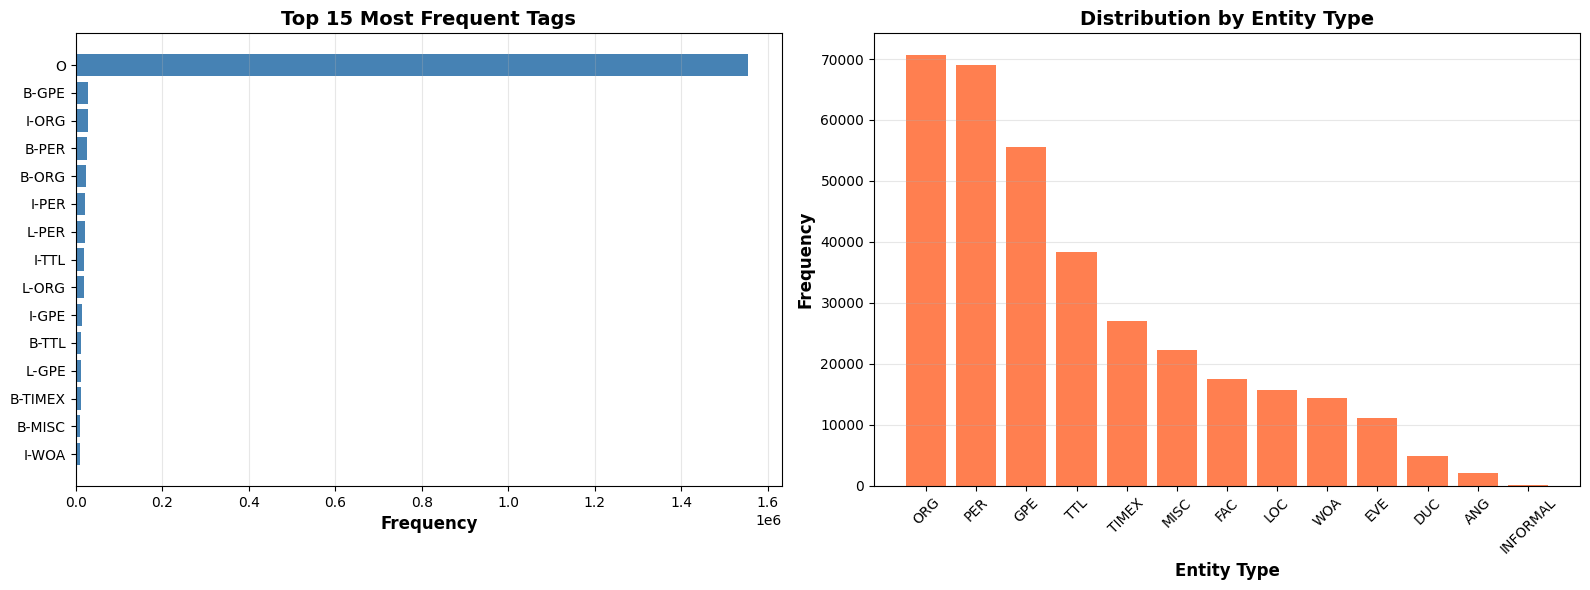

In [14]:
print("\n" + "="*70)
print("LABEL DISTRIBUTION ANALYSIS")
print("="*70)

# Count tag occurrences
tag_counts = {}
for tags in dataset["raw_tags"]:
    for tag in tags:
        tag_counts[tag] = tag_counts.get(tag, 0) + 1

# Convert to DataFrame for analysis
tag_df = pd.DataFrame(list(tag_counts.items()), columns=['Tag', 'Count'])
tag_df = tag_df.sort_values('Count', ascending=False)

print(f"\n📊 Top 10 most frequent tags:")
print(tag_df.head(10).to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Top 15 tags
tag_df_top = tag_df.head(15)
axes[0].barh(tag_df_top['Tag'], tag_df_top['Count'], color='steelblue')
axes[0].set_xlabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Top 15 Most Frequent Tags', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Entity type distribution
entity_types = {}
for tag in unique_tags:
    if tag != 'O':
        entity_type = tag.split('-')[1] if '-' in tag else 'OTHER'
        entity_types[entity_type] = entity_types.get(entity_type, 0) + tag_counts.get(tag, 0)

entity_df = pd.DataFrame(list(entity_types.items()), columns=['Entity', 'Count'])
entity_df = entity_df.sort_values('Count', ascending=False)

axes[1].bar(entity_df['Entity'], entity_df['Count'], color='coral')
axes[1].set_xlabel('Entity Type', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution by Entity Type', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ====================================================================
# 🔄 SECTION 6: Remap Labels to Numeric IDs
# ====================================================================

In [15]:
def remap_labels(examples):
    new_labels = []
    for raw_tags in examples["raw_tags"]:
        new_labels.append([label2id[tag] for tag in raw_tags])
    examples["ner_tags"] = new_labels
    return examples


In [16]:
training_dataset = training.map(remap_labels, batched=True)
testing_dataset = testing.map(remap_labels, batched=True)

Map:   0%|          | 0/38000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# ====================================================================
# 🤖 SECTION 7: Tokenizer Initialization
# ====================================================================


In [17]:
MODEL_NAME = "aubmindlab/bert-base-arabertv02"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# ====================================================================
# 🔧 SECTION 8: Tokenization and Label Alignment
# ====================================================================

In [18]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [19]:
training_dataset = training_dataset.map(tokenize_and_align_labels, batched=True)
testing_dataset = testing_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/38000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# ====================================================================
# 📦 SECTION 9: Data Collator
# ====================================================================

In [20]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# ====================================================================
# 📏 SECTION 10: Evaluation Metrics Setup
# ====================================================================

In [21]:
metric = evaluate.load("seqeval")

In [22]:
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(-1)  

    true_labels = []
    true_predictions = []

    for pred, label in zip(predictions, labels):
        temp_labels = []
        temp_preds = []
        for p_id, l_id in zip(pred, label):
            if l_id != -100: 
                temp_labels.append(id2label[l_id])
                temp_preds.append(id2label[p_id])
        true_labels.append(temp_labels)
        true_predictions.append(temp_preds)

    results = metric.compute(
        predictions=true_predictions, 
        references=true_labels,
        scheme=None,
        mode='strict',
        zero_division=0
    )
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }


# ====================================================================
# 🏗️ SECTION 11: Model Initialization
# ====================================================================

In [23]:
model = AutoModelForTokenClassification.from_pretrained("aubmindlab/bert-base-arabertv02",
                                                        num_labels=len(id2label),
                                                        label2id=label2id,
                                                        id2label=id2label)

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# ====================================================================
# ⚙️ SECTION 12: Training Configuration
# ====================================================================

In [24]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    num_train_epochs=10,
    save_total_limit=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,                         
    lr_scheduler_type="cosine",                
    warmup_ratio=0.1,                          
    gradient_accumulation_steps=1,             
    logging_dir='./logs',
    report_to="none",
    logging_strategy="epoch",
    fp16=True,                                 
)

# ====================================================================
# 🎯 SECTION 13: Trainer Setup
# ====================================================================


In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_dataset,
    eval_dataset=testing_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# ====================================================================
# 🚀 SECTION 14: Model Training
# ====================================================================


In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.490500,0.172955,0.833697,0.788581,0.810511,0.951217
2,0.150300,0.150319,0.854657,0.799587,0.826205,0.955283
3,0.109700,0.150311,0.848065,0.814033,0.830701,0.957152
4,0.081400,0.164041,0.842068,0.814263,0.827932,0.955547
5,0.057600,0.184016,0.841281,0.825269,0.833198,0.957300
6,0.040100,0.206550,0.854866,0.823894,0.839094,0.958166
7,0.028700,0.222104,0.849105,0.827104,0.837960,0.957416
8,0.020800,0.245324,0.845093,0.829397,0.837172,0.957627


TrainOutput(global_step=9504, training_loss=0.12240836796937166, metrics={'train_runtime': 5724.3798, 'train_samples_per_second': 66.383, 'train_steps_per_second': 2.075, 'total_flos': 3.125037659851008e+16, 'train_loss': 0.12240836796937166, 'epoch': 8.0})

# ====================================================================
# 💾 SECTION 15: Save Model and Tokenizer
# ====================================================================

In [27]:
trainer.save_model("./saved_model")
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [24]:
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/ner-token-classification/saved_model")
model = AutoModelForTokenClassification.from_pretrained("/kaggle/input/ner-token-classification/saved_model")

# ====================================================================
# 📈 SECTION 16: Training Results Visualization
# ====================================================================


TRAINING RESULTS VISUALIZATION


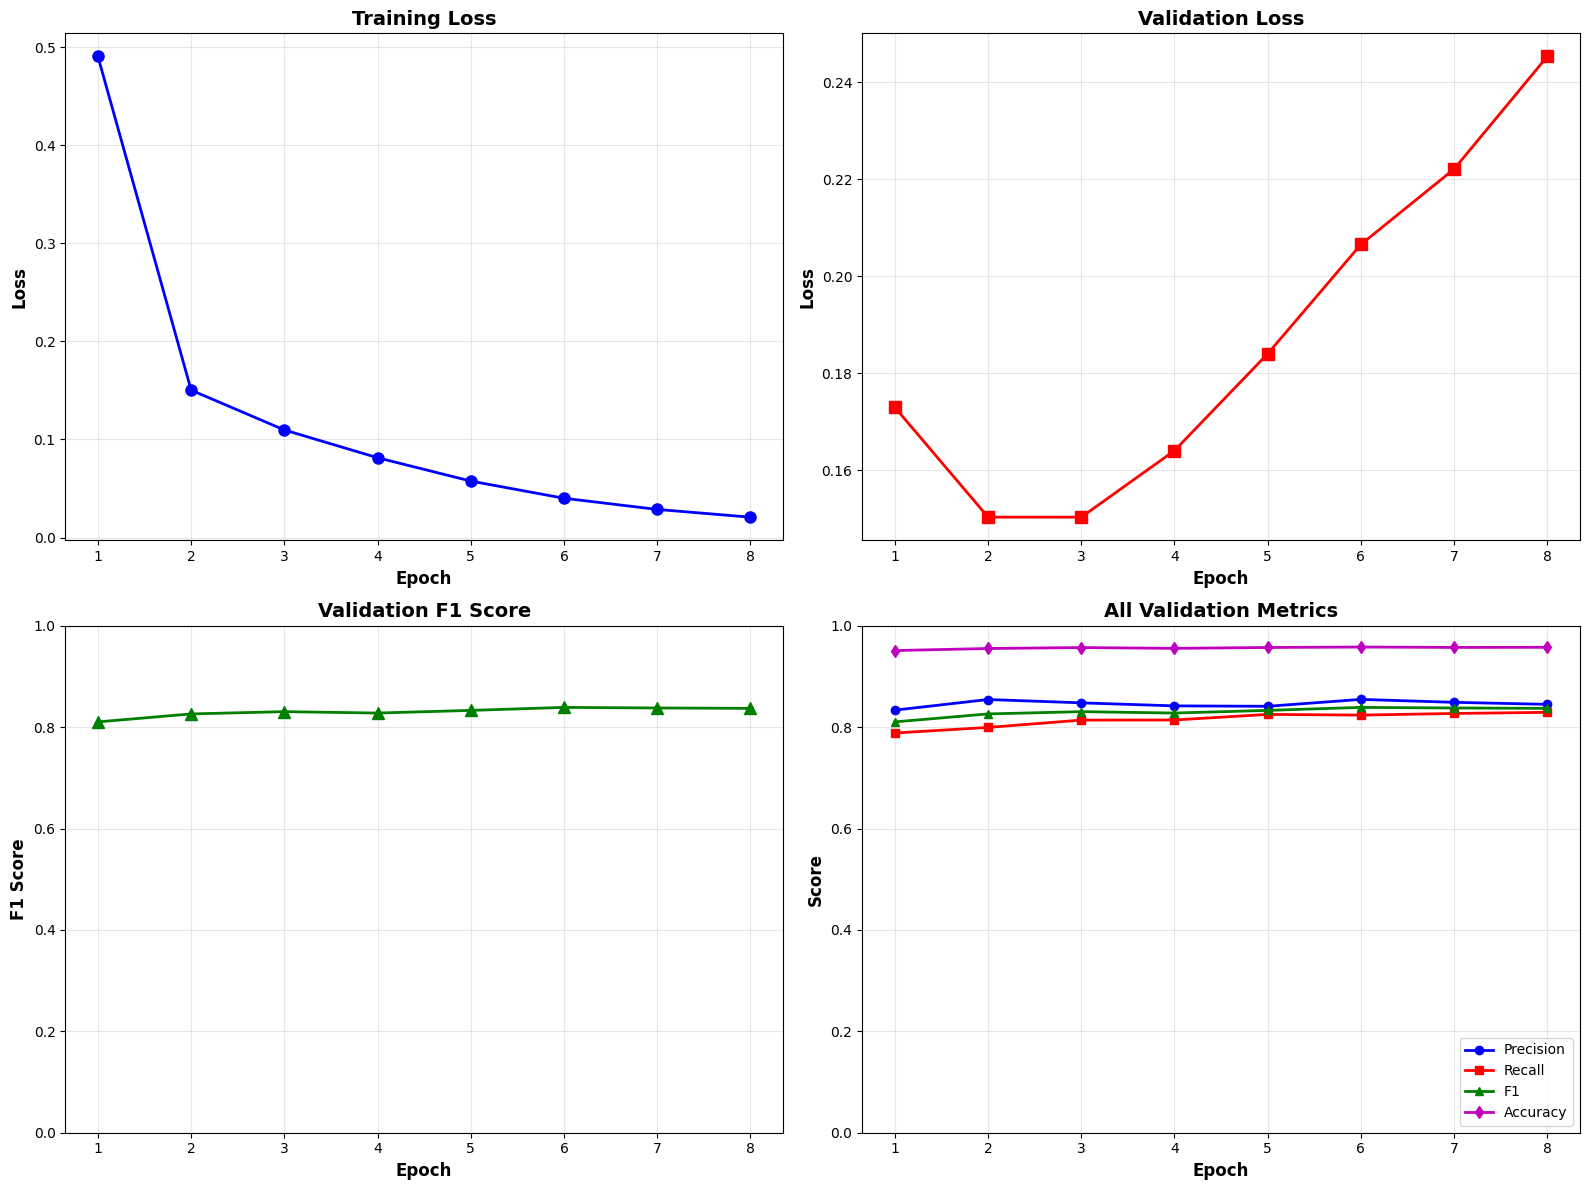

In [28]:
print("\n" + "="*70)
print("TRAINING RESULTS VISUALIZATION")
print("="*70)

# Extract training history
history = trainer.state.log_history

# Separate train and eval logs
train_logs = [log for log in history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in history if 'eval_loss' in log]

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Training Loss
if train_logs:
    epochs = [log['epoch'] for log in train_logs]
    losses = [log['loss'] for log in train_logs]
    axes[0, 0].plot(epochs, losses, 'b-o', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Training Loss', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Validation Loss
if eval_logs:
    eval_epochs = [log['epoch'] for log in eval_logs]
    eval_losses = [log['eval_loss'] for log in eval_logs]
    axes[0, 1].plot(eval_epochs, eval_losses, 'r-s', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

# Plot 3: F1 Score
if eval_logs:
    f1_scores = [log['eval_f1'] for log in eval_logs]
    axes[1, 0].plot(eval_epochs, f1_scores, 'g-^', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])

# Plot 4: All Metrics
if eval_logs:
    precision = [log['eval_precision'] for log in eval_logs]
    recall = [log['eval_recall'] for log in eval_logs]
    accuracy = [log['eval_accuracy'] for log in eval_logs]
    
    axes[1, 1].plot(eval_epochs, precision, 'b-o', label='Precision', linewidth=2)
    axes[1, 1].plot(eval_epochs, recall, 'r-s', label='Recall', linewidth=2)
    axes[1, 1].plot(eval_epochs, f1_scores, 'g-^', label='F1', linewidth=2)
    axes[1, 1].plot(eval_epochs, accuracy, 'm-d', label='Accuracy', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('All Validation Metrics', fontsize=14, fontweight='bold')
    axes[1, 1].legend(loc='lower right', fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# ====================================================================
# 🔮 SECTION 17: Inference Function
# ====================================================================

In [29]:
def ner_inference(tokens, tokenizer, model, id2label):
    inputs = tokenizer(tokens, return_tensors="pt", is_split_into_words=True, truncation=True)
    word_ids = inputs.word_ids()
    
    device = next(model.parameters()).device
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
   
    predictions = torch.argmax(outputs.logits, dim=2)
    
    predicted_labels = []
    previous_word_idx = None
    for idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == previous_word_idx:
            continue
        label_id = predictions[0][idx].item()
        predicted_labels.append(id2label[label_id])
        previous_word_idx = word_idx
    
    return predicted_labels

In [33]:
ENTITY_COLORS = {
    "PER": "#a2faa3",      
    "ORG": "#f9d162",       
    "LOC": "#72bcd4",       
    "GPE": "#8fbc8f",       
    "FAC": "#ffb6c1",       
    "TIMEX": "#d8bfd8",     
    "EVE": "#ffdead",      
    "TTL": "#ffa07a",       
    "DUC": "#b0e0e6",       
    "WOA": "#d2b48c",       
    "ANG": "#f08080",       
    "MISC": "#c0c0c0",      
    "INFORMAL": "#f4a460",  
}

In [30]:
def display_ner_results(tokens, actual_labels, predicted_labels):
    min_len = min(len(tokens), len(actual_labels), len(predicted_labels))
    df = pd.DataFrame({
        "Word": tokens[:min_len],
        "Actual Label": actual_labels[:min_len],
        "Predicted Label": predicted_labels[:min_len]
    })

    def colorize(val, is_actual=False):
        for ent, color in ENTITY_COLORS.items():
            if ent in val:
                if is_actual:
                    return f'background-color: {color}80; font-weight:bold;'
                else:
                    return f'background-color: {color}; font-weight:bold;'
        return ''

    styled = (
        df.style
        .map(lambda v: colorize(v, is_actual=True), subset=["Actual Label"])
        .map(lambda v: colorize(v, is_actual=False), subset=["Predicted Label"])
    )
    
    legend_html = "<div style='margin-bottom:10px;'>"
    for ent, color in ENTITY_COLORS.items():
        legend_html += f"<span style='background-color:{color}; padding:5px 10px; margin-right:5px; border-radius:5px;'>{ent}</span>"
    legend_html += "</div>"
    
    display(HTML(legend_html + styled.to_html()))

In [42]:
tokens = testing[1700]['tokens']
actual_labels = testing[1700]['raw_tags']

predicted_labels = ner_inference(tokens, tokenizer, model, id2label)

display_ner_results(tokens, actual_labels, predicted_labels)

,Word,Actual Label,Predicted Label
0,هبوعيل,B-ORG,B-ORG
1,شقيب,I-ORG,I-ORG
2,السلام,L-ORG,L-ORG
3,13,O,O
4,:,O,O
5,45,O,O
6,نادي,B-ORG,B-ORG
7,ا,I-ORG,I-ORG
8,ٔ,I-ORG,I-ORG
9,ور,I-ORG,I-ORG
